In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pysr import PySRRegressor

In [2]:
import matplotlib
COLOR = 'white'
import matplotlib as mpl
mpl.rcParams['text.color'] = "black"
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

import warnings
warnings.filterwarnings('ignore')

### Helpers

Compute numerical derivative

In [4]:
def make_experiment_dataset(t, m, k, func, label):
    x = func(t, k, m)
    #ddx_ddt, dx_dt, x, t = compute_2nd_derivative(x, t)

    dx_dt = np.gradient(x, t)
    ddx_ddt = np.gradient(dx_dt, t)

    X = pd.DataFrame(data= np.array([x, t, ddx_ddt, dx_dt]).T, columns=["x", "t", "ddx_ddt", "dx_dt"])
    X["m"] = m
    X["label"] = label
    return X

## Models

### Oscillator

#### Theoretical Model

$$F=-kx=m\ddot{x}$$
$$Ansatz: \quad x(t) = C *e^{i\omega t}$$
$$=>  \omega = \pm \sqrt{\frac{k}{m}}$$ 

with initial conditions: 
$$x(0) = -1, \quad  \dot{x}(0) = 0$$

the solution becomes:

$$x(t) = -cos(\omega t)$$

In [5]:
def osc(t, k, m):
    omega = np.sqrt(k/m)
    x = -np.cos(omega*t)
    return x

Two Experiments with different masses:

In [6]:
t = np.linspace(0,10, 1000)
k = 2

m1 = 1.5
X1 = make_experiment_dataset(t, m1, k, osc, "experiment_1")

m2 = 3
X2 = make_experiment_dataset(t, m2, k, osc, "experiment_2")

X = pd.concat([X1, X2])

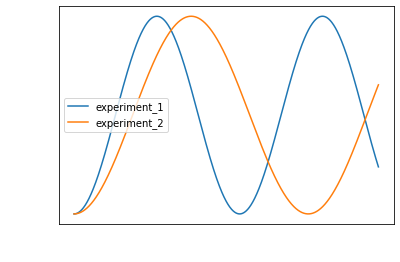

In [7]:
plt.plot( X1.t, X1.x, label = "experiment_1")
plt.plot( X2.t, X2.x, label = "experiment_2")
plt.xlabel("t")
plt.ylabel("x")
plt.legend();

#### Symbolic Regression

In [8]:
import os
num_threads = 10
os.environ["JULIA_NUM_THREADS"] = f"{num_threads}"

model = PySRRegressor(
    model_selection = 'best',
    niterations = 100,
    populations = 30,
    binary_operators = ['+', '*', "-", "/"],
    unary_operators = [
        'sin',
        'cos',
        'exp',
        'sqrt_abs',
        "inv(x) = 1/x"
    ],
    extra_sympy_mappings = {
        'inv': lambda x: 1/x
        },
    loss = 'loss(x, y) = (x - y)^2',
    procs=num_threads,
    multithreading=False,
    complexity_of_constants=3,
    complexity_of_variables=1,  # only use integers, else error!
    #parsimony= 0.005 #default = 0.0032
    # other interesting parameters include:  complexity_of_operators, constraints, nested_constraints
)

In [9]:
# Finding the ODE
model.fit(X[["t", "dx_dt", "ddx_ddt", "m"]], X.x)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                              dx_dt   
	1         0.366391                                             inv(m)   
	2         1.411901                                  cos(exp(ddx_ddt))   
	3         0.050639                             sin(cos(exp(ddx_ddt)))   
	4         1.275296                            (ddx_ddt * -0.90144473)   
	5         0.644474                          sin(ddx_ddt * -1.3549223)   
	6   >>>>  4.227786                      ((ddx_ddt * m) * -0.50055516)   
	7         0.043522   ((sin(ddx_ddt) * (m + cos(dx_dt))) * -0.4043356)   
	8         0.068241  (((ddx_ddt + (0.00053744524 / (t + dx_dt))) * ...   
	9         0.046190  (((ddx_ddt + ((0.00053744524 / exp(t)) / dx_dt...   
	10        0.091353  (((ddx_ddt + (0.00053744524 / ((t + dx_dt) / m...   
	11        0.130147  (((ddx_ddt + ((0.00053744524 / exp(t - ddx_ddt...   
	12        0.497848  (((ddx_ddt + (0.00053744524 / ((t + 0.00053744...   
	
	        loss  complexity  
	0   1.081357           1  
	1   0.749631           2  
	2   0.182670           3  
	3   0.173650           4  
	4   0.048509           5  
	5   0.025464           6  
	6   0.000371           7  
	7   0.000312          11  
	8   0.000238          15  
	9   0.000227          16  
	10  0.000207          17  
	11  0.000182          18  
	12  0.000110          19  
]

#### Damped Oscillator

In [11]:
x_0 = 2
m = 1
k = 2
omega = np.sqrt(k/m)
delta = 0.5

def damped_osc(t, omega, delta):
    x = x_0*np.cos(omega*t)*np.exp(-delta*t)
    return x

t = np.linspace(0, 10, 1000)  #.reshape(-1, 1)
x = damped_osc(t, omega, delta)

$$
\begin{align}
x(t) & = x_0*cos(\omega*t)*e^{-\delta*t} \\
& = 2*cos(10*t)*e^{-0.5*t}
\end{align}
$$

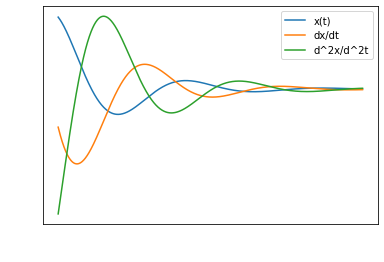

In [13]:
plt.plot(t, x, label="x(t)")
plt.plot(t, dx_dt, label="dx/dt")
plt.plot(t, d2x_dt, label="d^2x/d^2t")
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend();

In [14]:
model = PySRRegressor(
    model_selection = 'best',
    niterations = 40,
    binary_operators = ['+', '*'],
    unary_operators = [
        'sin',
        'cos',
        'exp',
        'inv(x) = 1/x',
    ],
    extra_sympy_mappings = {'inv': lambda x: 1/x},
    loss = 'loss(x, y) = (x - y)^2',
)

In [15]:
X = pd.DataFrame(columns={"d2x_d2t": d2x_dt, "dx_dt": dx_dt, "x": x, "t": t})

In [16]:
model.fit(X, x)

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by PySRRegressor.

In [ ]:
solution = model.equations_
solution = solution.loc[solution['score'] == solution['score'].max(), 'sympy_format'].item()

solution

2.00004483938274*exp(-0.50003445*x0)*cos(10.000001*x0)

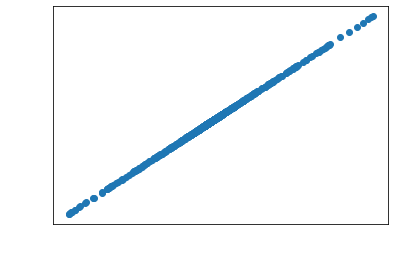

In [ ]:
x_pred = model.predict(t)

plt.scatter(x, x_pred)
plt.xlabel('x')
plt.ylabel('x_pred')
plt.show()